In [11]:
%pip install gdown
%pip install lightgbm
import pandas as pd
import lightgbm as lgb
import gdown
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://drive.google.com/drive/folders/1gq7XBf4MKWi2JpCHdfjiPXzu8Db2p31n?usp=sharing"
gdown.download_folder(url, quiet=True)


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


['c:\\Users\\adria\\OneDrive\\Documenti\\Università\\Foundation of data science\\project\\Dataset\\test.csv',
 'c:\\Users\\adria\\OneDrive\\Documenti\\Università\\Foundation of data science\\project\\Dataset\\train.csv',
 'c:\\Users\\adria\\OneDrive\\Documenti\\Università\\Foundation of data science\\project\\Dataset\\training.csv']

**LightGBM with label-encoding**

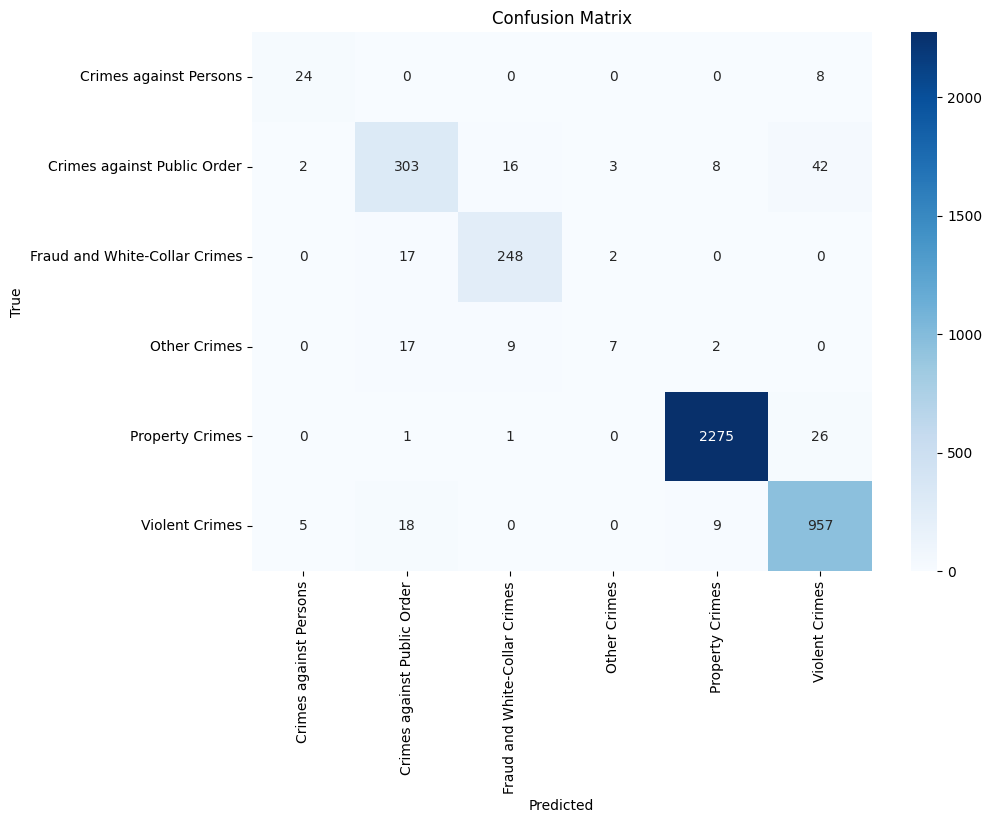

Classification Report:
                               precision    recall  f1-score   support

       Crimes against Persons       0.77      0.75      0.76        32
  Crimes against Public Order       0.85      0.81      0.83       374
Fraud and White-Collar Crimes       0.91      0.93      0.92       267
                 Other Crimes       0.58      0.20      0.30        35
              Property Crimes       0.99      0.99      0.99      2303
               Violent Crimes       0.93      0.97      0.95       989

                     accuracy                           0.95      4000
                    macro avg       0.84      0.77      0.79      4000
                 weighted avg       0.95      0.95      0.95      4000
 

Accuracy:  0.9535


In [9]:
X = pd.read_csv("Dataset/train.csv", sep = ';')
y = X['Crime_Category']
X = X.drop('Crime_Category', axis=1)

# remove column with 80% null values
X = X.drop('Cross_Street', axis=1)

# handle missing data
X['Victim_Sex'] = X['Victim_Sex'].replace(['H', 'X'], 'Unknown')
X['Victim_Descent'] = X['Victim_Descent'].fillna('Unknown')
X['Weapon_Description'] = X['Weapon_Description'].fillna('No Weapon')
X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(0) # Weapon_Used_Code is in the range [1,3990], 0 is for missing code
X['Modus_Operandi'] = X['Modus_Operandi'].fillna('Unknown')

# data handling
X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Year_Reported'] = X.Date_Reported.dt.year
X['Year_Occurred'] = X.Date_Occurred.dt.year
X['Month_Reported'] = X.Date_Reported.dt.month
X['Month_Occurred'] = X.Date_Occurred.dt.month
X['Day_Reported'] = X.Date_Reported.dt.day
X['Day_Occurred'] = X.Date_Occurred.dt.day
X.drop(['Date_Reported', 'Date_Occurred'], axis=1, inplace=True)

numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

def label_encoding_column(df, column):
    lab_encoder = LabelEncoder()
    df[column] = lab_encoder.fit_transform(df[column])
    return df

for col in categorical_columns:
  if col == 'Modus_Operandi':
    continue
  X = label_encoding_column(X, col)

modus_operandi_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    CountVectorizer(preprocessor=lambda x:x[0])
)

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_columns),
    ('modus_operandi', modus_operandi_pipeline, ['Modus_Operandi'])
  ])

# 7. Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert the transformed data back to dense if needed (LightGBM accetta sparse CSR, quindi non serve)
# Qui possiamo lasciare i dati in formato CSR.

# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 8. Create the LightGBM Dataset
train_set = lgb.Dataset(X_train_transformed, label=y_train_encoded)

# 9. Model parameters (for multiclass classification)
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_encoded)),  # Number of classes in the target
    'metric': 'multi_logloss',  # Metrics for classification
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'boosting_type': 'gbdt',
    'verbose': -1,
    'feature_fraction': 0.8
}

# 10. Train the model with validation and early stopping
bst = lgb.train(
    params,
    train_set,
    num_boost_round=100,
)

# 11. Predictions
y_pred_proba = bst.predict(X_test_transformed)  # Use transformed test set
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# 12. Visualize the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 13. Classification report (precision, recall, F1-score)
class_report = classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report, '\n')

# Accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print("Accuracy: ", accuracy)

**LightGBM with one-hot-encoding**

c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


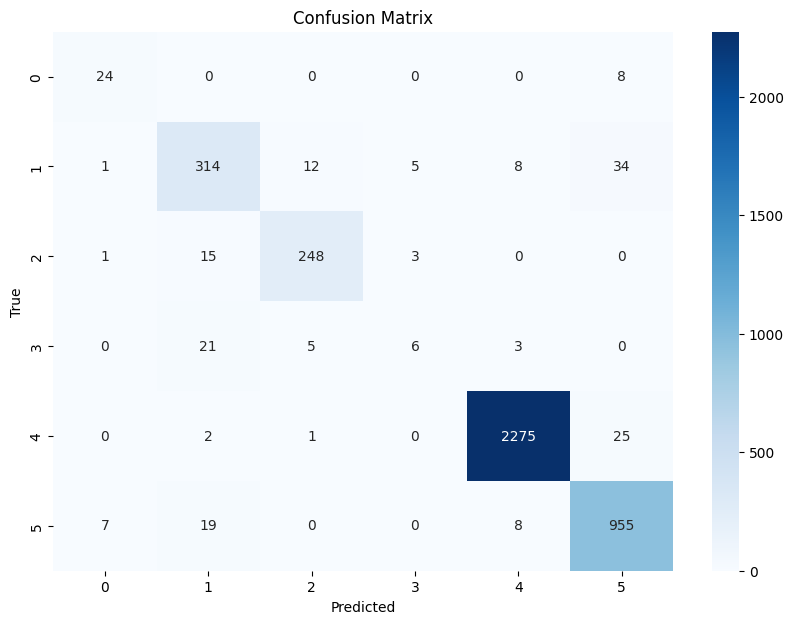

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        32
           1       0.85      0.84      0.84       374
           2       0.93      0.93      0.93       267
           3       0.43      0.17      0.24        35
           4       0.99      0.99      0.99      2303
           5       0.93      0.97      0.95       989

    accuracy                           0.96      4000
   macro avg       0.81      0.77      0.78      4000
weighted avg       0.95      0.96      0.95      4000
 

Accuracy:  0.9555


In [12]:
# 1. Load the dataset
X = pd.read_csv("Dataset/train.csv", sep=';')
y = X['Crime_Category']
X = X.drop('Crime_Category', axis=1)

# 2. Remove column with 80% null values
X.drop('Cross_Street', axis=1, inplace=True)

# 3. Handle missing data
X['Victim_Sex'] = X['Victim_Sex'].replace(['H', 'X'], 'Unknown')
X['Victim_Descent'] = X['Victim_Descent'].fillna('Unknown')
X['Weapon_Description'] = X['Weapon_Description'].fillna('No Weapon')
X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(0)  # Weapon_Used_Code is in the range [1,3990], 0 is for missing code
X['Modus_Operandi'] = X['Modus_Operandi'].fillna('Unknown')

# 4. Handle date columns
X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Year_Reported'] = X.Date_Reported.dt.year
X['Year_Occurred'] = X.Date_Occurred.dt.year
X['Month_Reported'] = X.Date_Reported.dt.month
X['Month_Occurred'] = X.Date_Occurred.dt.month
X['Day_Reported'] = X.Date_Reported.dt.day
X['Day_Occurred'] = X.Date_Occurred.dt.day
X.drop(['Date_Reported', 'Date_Occurred'], axis=1, inplace=True)

# 5. Separate numerical and categorical features
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
categorical_columns = [col for col in categorical_columns if col != 'Modus_Operandi']

# 6. Pipelines for data preprocessing
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
)

modus_operandi_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    CountVectorizer(preprocessor=lambda x: x[0])
)

# 7. Preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns),
    ('modus_operandi', modus_operandi_pipeline, ['Modus_Operandi'])
])

# 8. Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode target labels
y_encoder = LabelEncoder()
y_train_encoded = y_encoder.fit_transform(y_train)
y_test_encoded = y_encoder.transform(y_test)

# 9. Create the LightGBM Dataset
train_set = lgb.Dataset(preprocessor.fit_transform(X_train), label=y_train_encoded)

# 10. Model parameters (for multiclass classification)
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_encoded)),  # Number of classes in the target
    'metric': 'multi_logloss',  # Metrics for classification
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'boosting_type': 'gbdt',
    'verbose': -1,
    'feature_fraction': 0.8
}

# 11. Train the model with validation and early stopping
bst = lgb.train(
    params,
    train_set,
    num_boost_round=100,
)

# 12. Predictions
y_pred_proba = bst.predict(preprocessor.transform(X_test))
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# 13. Visualize the Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
print('\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_encoded), yticklabels=np.unique(y_test_encoded))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 14. Classification report (precision, recall, f1-score)
class_report = classification_report(y_test_encoded, y_pred_classes)
print("Classification Report:")
print(class_report,'\n')

accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print('Accuracy: ', accuracy)